<a href="https://colab.research.google.com/github/Shaheer04/Pakistani-Food-Classification/blob/main/FoodClassificationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn



torch.__version__

'2.5.1+cu121'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "biryani_bbq_fries"

if image_path.is_dir():
    print(f"{image_path} directory already exists")
else:
    print(f"creating {image_path} directory")
    image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "biryani_bbq_fries.zip", "wb") as f:
  request = requests.get("https://github.com/Shaheer04/Pakistani-Food-Classification/raw/refs/heads/main/Food-dataset.zip")
  print("Downloading biryani, bbq, fries data...")
  f.write(request.content)

  # Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "biryani_bbq_fries.zip", "r") as zip_ref:
  print("Unzipping biryani, bbq and fries data...")
  zip_ref.extractall(image_path)



data/biryani_bbq_fries directory already exists
Unzipping biryani, bbq and fries data...


In [ ]:
import os
def walk_through_dir(dir_path):

  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir(image_path)

There are 1 directories and 0 images in 'data/biryani_bbq_fries'.
There are 3 directories and 0 images in 'data/biryani_bbq_fries/Fooddataset'.
There are 0 directories and 100 images in 'data/biryani_bbq_fries/Fooddataset/biryani'.
There are 0 directories and 100 images in 'data/biryani_bbq_fries/Fooddataset/french_fries'.
There are 0 directories and 100 images in 'data/biryani_bbq_fries/Fooddataset/bbq'.


In [ ]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/biryani_bbq_fries/train'),
 PosixPath('data/biryani_bbq_fries/test'))

## Visualizing Images

Random image path: data/biryani_bbq_fries/Fooddataset/biryani/biryani32.jpg
Image class: biryani
Image height: 225
Image width: 225


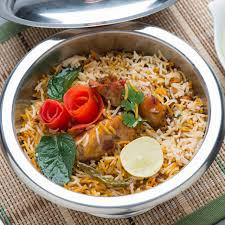

In [ ]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

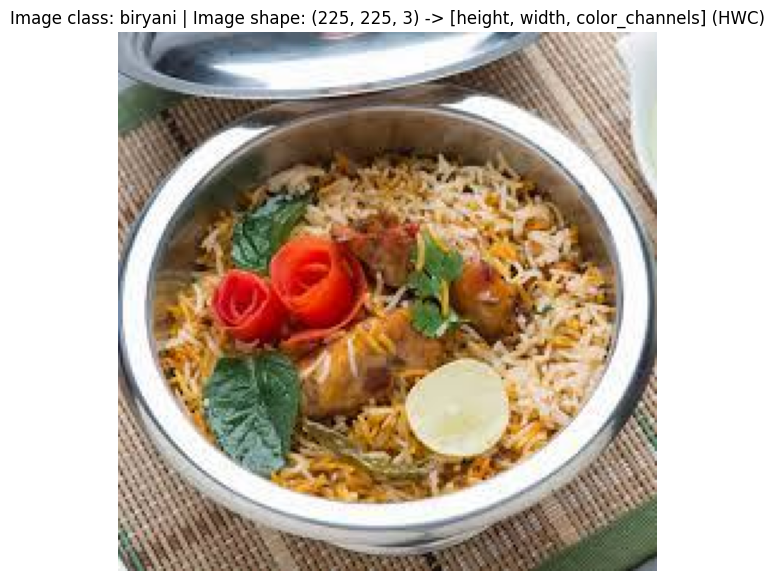

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False);

array([[[144, 154, 166],
        [157, 167, 179],
        [150, 160, 172],
        ...,
        [235, 236, 238],
        [232, 236, 237],
        [227, 232, 236]],

       [[146, 156, 168],
        [157, 167, 179],
        [153, 163, 175],
        ...,
        [234, 235, 237],
        [231, 235, 236],
        [226, 231, 235]],

       [[149, 159, 171],
        [158, 168, 180],
        [158, 168, 180],
        ...,
        [232, 233, 235],
        [229, 233, 234],
        [225, 230, 234]],

       ...,

       [[238, 243, 236],
        [228, 231, 224],
        [173, 172, 167],
        ...,
        [102, 108, 108],
        [108, 116, 119],
        [113, 119, 131]],

       [[253, 254, 249],
        [227, 229, 224],
        [237, 239, 234],
        ...,
        [115, 123, 126],
        [113, 120, 128],
        [118, 126, 139]],

       [[232, 234, 233],
        [234, 238, 237],
        [236, 241, 237],
        ...,
        [106, 117, 123],
        [115, 125, 134],
        [118, 126, 139]]], dtype=uint8)
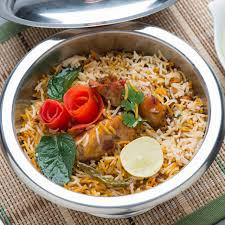

In [ ]:
img_as_array

## 3. Transforming data

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
# Write a transform for image
data_transform = transforms.Compose([
  # Resize our images to 64x64
  transforms.Resize(size=(64, 64)),
  # Flip the images randomly on the horizontal
  transforms.RandomHorizontalFlip(p=0.5),
  # Turn the image into a torch.Tensor
  transforms.ToTensor()
])

In [ ]:
data_transform(img).shape

torch.Size([3, 64, 64])

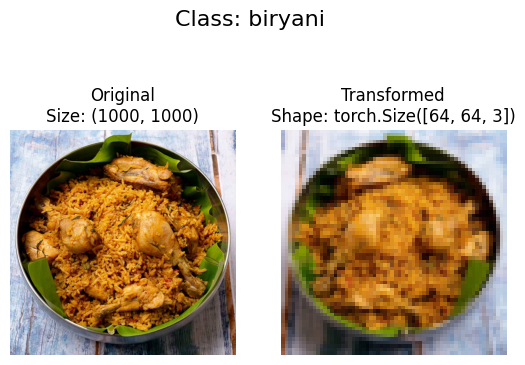

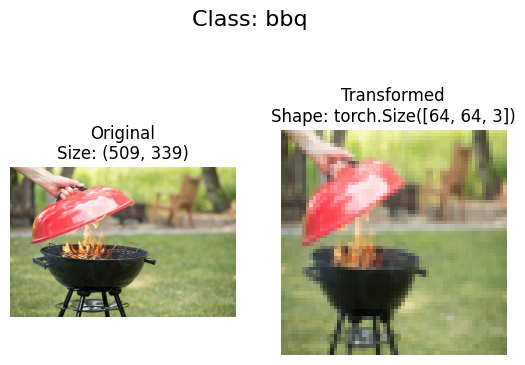

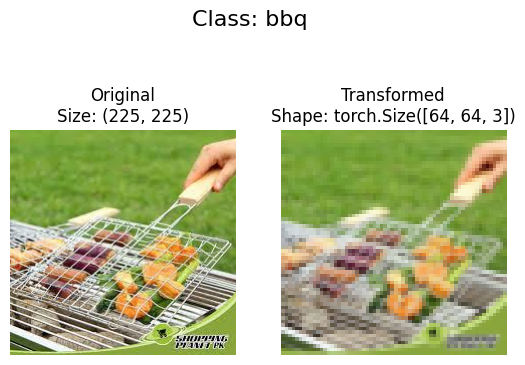

In [ ]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)

## Splitting into train/test and Transforming Data

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
from sklearn.model_selection import train_test_split
import numpy as np

# Custom dataset wrapper to apply transforms
class TransformDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.subset[index]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.subset)

In [ ]:
from torchvision import transforms

def get_mean_std(loader):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_pixels = 0
    mean = 0.0
    std = 0.0
    for images, _ in loader:
        # Convert images to tensors if they are not already
        if not isinstance(images, torch.Tensor):
            images = transforms.ToTensor()(images)

        batch_size, num_channels, height, width = images.shape
        num_pixels += batch_size * height * width
        mean += images.mean(axis=(0, 2, 3)).sum()
        std += images.std(axis=(0, 2, 3)).sum()

    mean /= num_pixels
    std /= num_pixels

    return mean, std

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), # Apply ToTensor transform here
])

batch_size = 32
# Apply transform to the dataset when creating the DataLoader
loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(
        root='/content/data/biryani_bbq_fries/Fooddataset',
        transform=data_transforms # Apply transforms here
    ),
    batch_size=batch_size,
    shuffle=True
)
mean, std = get_mean_std(loader)

In [ ]:
# # Write a transform for image
# data_transform = transforms.Compose([
#   # Resize our images to 64x64
#   transforms.Resize(size=(64, 64)),
#   # Flip the images randomly on the horizontal
#   transforms.RandomHorizontalFlip(p=0.5),
#   # Turn the image into a torch.Tensor
#   transforms.ToTensor()
# ])

train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [ ]:
# Load full dataset
full_dataset = datasets.ImageFolder(
    root='/content/data/biryani_bbq_fries/Fooddataset',
    transform=None  # No transform applied here yet
)

# Stratified split using sklearn
indices = list(range(len(full_dataset)))
labels = [label for _, label in full_dataset.imgs]

train_indices, test_indices = train_test_split(
    indices,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# Create subsets with transforms
train_subset = TransformDataset(
    Subset(full_dataset, train_indices),
    transform=train_transform
)

test_subset = TransformDataset(
    Subset(full_dataset, test_indices),
    transform=test_transform
)


# Verify counts
print(f"Total images: {len(full_dataset)}")
print(f"Training images: {len(train_subset)}")
print(f"Testing images: {len(test_subset)}")
print(f"Class names: {full_dataset.classes}")

Total images: 300
Training images: 240
Testing images: 60
Class names: ['bbq', 'biryani', 'french_fries']


In [ ]:
import os
os.cpu_count()

2

In [ ]:
# Create dataloaders
BATCH_SIZE = 1

train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x79a484400250>,
 <torch.utils.data.dataloader.DataLoader at 0x79a461a8fe50>)

In [ ]:
len(train_loader) , len(test_loader)

(240, 60)

In [ ]:
img, label = next(iter(train_loader))


# Batch is one now, but we can change it later if we want to!
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")


Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


### Create a function to display random images

In [ ]:
# 1. Create a function to take in a dataset
from typing import List
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)


In [ ]:
class_names = full_dataset.classes

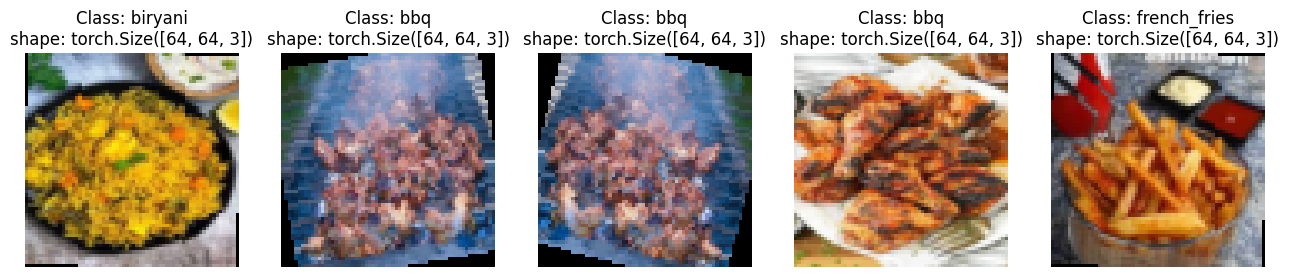

In [ ]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_subset,
                      n=5,
                      classes=class_names,
                      seed=None)

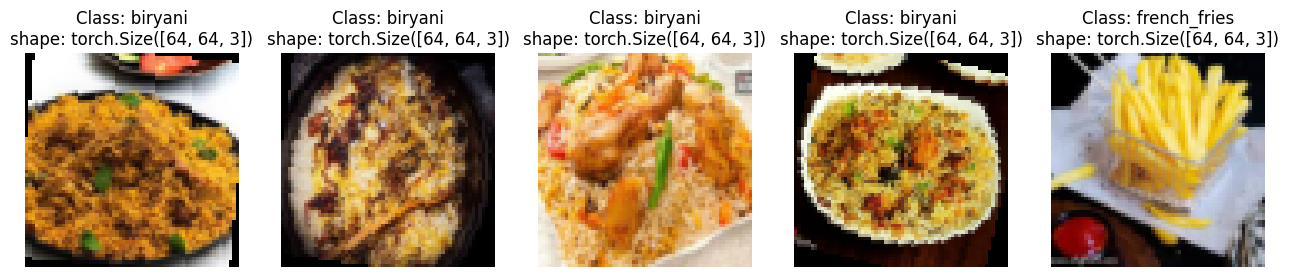

In [ ]:
display_random_images(train_subset,
                      n=5,
                      classes=class_names,
                      seed=None)

## Model 0: TinyVGG without data augmentation

In [ ]:
# Create dataloaders
BATCH_SIZE = 32

train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x79a4843a9090>,
 <torch.utils.data.dataloader.DataLoader at 0x79a461ac8790>)

In [ ]:
img, label = next(iter(train_loader))


# Batch is one now, but we can change it later if we want to!
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [ ]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion: https://horace.io/brrr_intro.html


In [ ]:
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### Try a forward pass on a single image (to test the model)

In [ ]:
# Get a single image batch
image_batch, label_batch = next(iter(train_loader))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[ 0.0323, -0.0112,  0.0060],
        [ 0.0470,  0.0377, -0.0042],
        [ 0.0694,  0.0665,  0.0432],
        [ 0.0349,  0.0495,  0.0159],
        [-0.0184, -0.0096, -0.0660],
        [ 0.0142,  0.0108, -0.0018],
        [ 0.0324,  0.0246, -0.0565],
        [ 0.0450,  0.0688, -0.0675],
        [ 0.0436,  0.0175,  0.0315],
        [ 0.0611,  0.0645,  0.0128],
        [ 0.0064,  0.0358,  0.0158],
        [ 0.0373,  0.0032, -0.0110],
        [ 0.0529,  0.0409, -0.0025],
        [ 0.0352,  0.0786, -0.0265],
        [ 0.0473, -0.0049,  0.0234],
        [-0.0045, -0.0281,  0.0195],
        [ 0.0504,  0.0012,  0.0108],
        [ 0.0026, -0.0293,  0.0001],
        [-0.0558, -0.0403, -0.0401],
        [-0.0120, -0.0102,  0.0059],
        [ 0.0365,  0.0890, -0.0476],
        [ 0.0289,  0.0453, -0.0320],
        [ 0.0136,  0.0005,  0.0046],
        [ 0.0170,  0.0468,  0.0002],
        [-0.0353,  0.0035,  0.0149],
        [-0.0130, -0.0032,  0.0066],
        [-0.0319,  0.0131, -0.0335],
 

### Using torchinfo to get an idea of the shapes going through our model

In [ ]:
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─BatchNorm2d: 2-4                  [1, 10, 60, 60]           20
│    └─ReLU: 2-5                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-6                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-7                       [1, 10, 28, 28]           910
│    └─ReLU: 2-8                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-9                       [1, 10, 26, 26]           910
│    └─ReLU: 2-10                        [1, 10, 26, 26]           --
│    └─MaxP

### Create train and test loops functions
train_step() - takes in a model and dataloader and trains the model on the dataloader.

test_step() - takes in a model and dataloader and evaluates the model on the dataloader.

In [ ]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # output model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [ ]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0,  0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc


In [ ]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    # 4. Print out what's happening
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results

 ## Train and evaluate model 0

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 100

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels of our target images
                  hidden_units=10,
                  output_shape=len(full_dataset.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=1e-5, weight_decay=1e-5)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.0987 | Train acc: 0.3281 | Test loss: 1.0990 | Test acc: 0.3259
Epoch: 10 | Train loss: 1.0840 | Train acc: 0.4336 | Test loss: 1.0871 | Test acc: 0.3839
Epoch: 20 | Train loss: 1.0675 | Train acc: 0.3945 | Test loss: 1.0744 | Test acc: 0.3862
Epoch: 30 | Train loss: 1.0498 | Train acc: 0.4609 | Test loss: 1.0556 | Test acc: 0.4219
Epoch: 40 | Train loss: 1.0178 | Train acc: 0.4961 | Test loss: 1.0274 | Test acc: 0.4911
Epoch: 50 | Train loss: 0.9723 | Train acc: 0.6211 | Test loss: 0.9882 | Test acc: 0.6071
Epoch: 60 | Train loss: 0.9360 | Train acc: 0.6094 | Test loss: 0.9427 | Test acc: 0.5871
Epoch: 70 | Train loss: 0.8599 | Train acc: 0.6680 | Test loss: 0.8925 | Test acc: 0.6183
Epoch: 80 | Train loss: 0.8216 | Train acc: 0.6719 | Test loss: 0.8452 | Test acc: 0.6518
Epoch: 90 | Train loss: 0.7597 | Train acc: 0.6953 | Test loss: 0.8055 | Test acc: 0.6496
Total training time: 327.396 seconds


In [ ]:
model_0_results

{'train_loss': [1.0987270325422287,
  1.0969769656658173,
  1.0975157022476196,
  1.0922303348779678,
  1.0899284929037094,
  1.0918921828269958,
  1.0925705134868622,
  1.0859520584344864,
  1.0899486988782883,
  1.0849932432174683,
  1.084002286195755,
  1.0819232612848282,
  1.0823641270399094,
  1.0781110525131226,
  1.0788497924804688,
  1.0773944556713104,
  1.0748236030340195,
  1.0764971524477005,
  1.078157678246498,
  1.0765859633684158,
  1.0674703121185303,
  1.0706458687782288,
  1.0686705857515335,
  1.064042866230011,
  1.0632814019918442,
  1.0551901906728745,
  1.0611004829406738,
  1.0551202297210693,
  1.050625890493393,
  1.0552709698677063,
  1.049798458814621,
  1.0471413731575012,
  1.043031558394432,
  1.0397603958845139,
  1.0378935635089874,
  1.0344886034727097,
  1.0343473106622696,
  1.0261607840657234,
  1.0335043892264366,
  1.0249415263533592,
  1.0178452283143997,
  1.0188985168933868,
  1.0061460062861443,
  1.0157382115721703,
  1.0012509748339653,
  

### Plot the loss curves of Model 0

A loss curve is a way of tracking your model's progress over time.

A good guide for different loss curves can be seen here: https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

In [ ]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
from typing import Dict
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary."""
  # Get the loss values of the results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how mnay epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

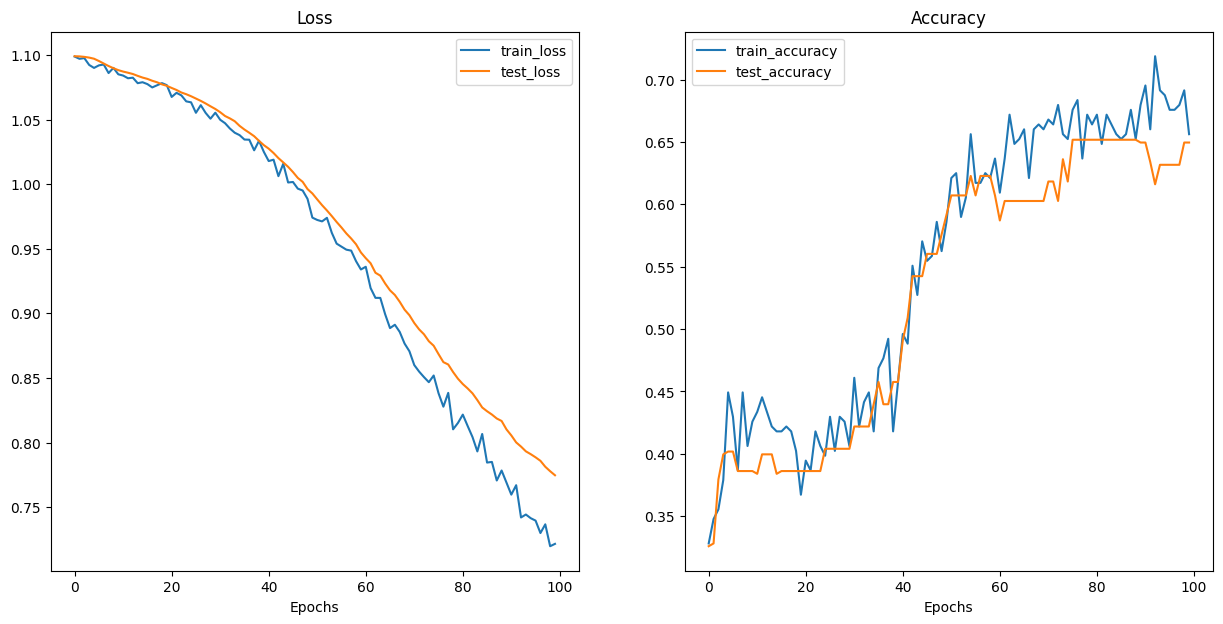

In [ ]:
plot_loss_curves(model_0_results)

In [ ]:
# Create training transform with TriviailAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
                                               transforms.Resize(size=(64, 64)),
                                               transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                               transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
                                            transforms.Resize(size=(64, 64)),
                                            transforms.ToTensor()
])

In [ ]:
# Create subsets with transforms
train_subset_augmented = TransformDataset(
    Subset(full_dataset, train_indices),
    transform=train_transform_trivial
)

test_subset = TransformDataset(
    Subset(full_dataset, test_indices),
    transform=test_transform_simple
)

In [ ]:
# Turn our Datasets into DataLoaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_subset_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_subset,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

In [ ]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(full_dataset.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [ ]:
#Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 10

# Setup loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001, weight_decay=1e-5)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1064 | Train acc: 0.2852 | Test loss: 1.0947 | Test acc: 0.3393
Epoch: 10 | Train loss: 0.6628 | Train acc: 0.6602 | Test loss: 0.6671 | Test acc: 0.6830
Epoch: 20 | Train loss: 0.5185 | Train acc: 0.7969 | Test loss: 0.6142 | Test acc: 0.6719
Total training time for model_1: 97.633 seconds


### Plot the loss curves of model 1

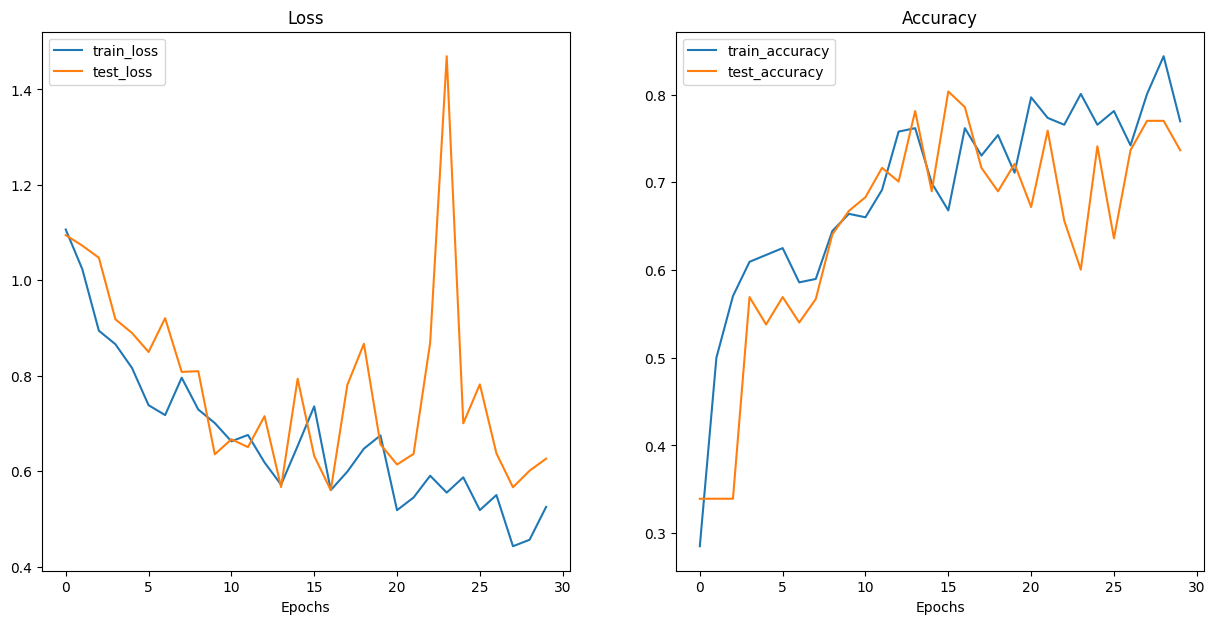

In [ ]:
plot_loss_curves(model_1_results)

### Compare Both Models

In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.098727,0.328125,1.098977,0.325893
1,1.096977,0.347656,1.098843,0.328125
2,1.097516,0.355469,1.098472,0.379464
3,1.092230,0.378906,1.097910,0.399554
4,1.089928,0.449219,1.097045,0.401786
...,...,...,...,...
95,0.739551,0.675781,0.788543,0.631696
96,0.729931,0.675781,0.785833,0.631696
97,0.736678,0.679688,0.781235,0.631696
98,0.719734,0.691406,0.777794,0.649554


ValueError: x and y must have same first dimension, but have shapes (100,) and (30,)

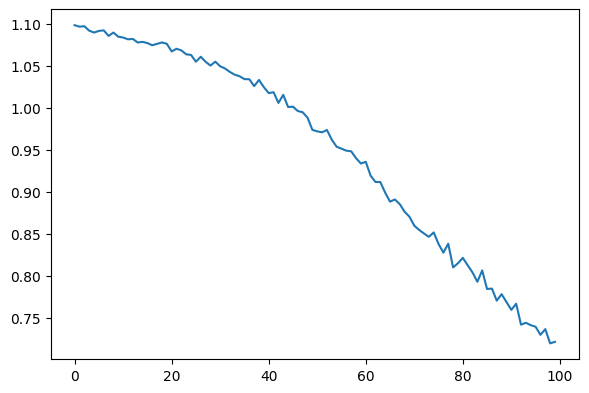

In [ ]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend();


### Making a prediction on a custom image (That is not in our dataset)

In [ ]:
import requests

custom_image_path = data_path / "biryani.jpg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://github.com/Shaheer04/Pakistani-Food-Classification/blob/main/biryani_img.jpg?raw=true")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")


In [ ]:
custom_image_path

PosixPath('data/biryani.jpg')

In [ ]:
import torchvision
# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
custom_image

tensor([[[0.7765, 0.7686, 0.7608,  ..., 0.5725, 0.5961, 0.6118],
         [0.7922, 0.7882, 0.7882,  ..., 0.5882, 0.6039, 0.6118],
         [0.7882, 0.7843, 0.7843,  ..., 0.6157, 0.6235, 0.6235],
         ...,
         [0.7059, 0.6941, 0.6863,  ..., 0.0863, 0.0784, 0.0824],
         [0.6902, 0.6863, 0.6863,  ..., 0.2392, 0.2392, 0.2431],
         [0.6784, 0.6745, 0.6824,  ..., 0.2745, 0.2902, 0.2863]],

        [[0.8902, 0.8824, 0.8784,  ..., 0.4431, 0.4745, 0.4902],
         [0.9059, 0.9020, 0.9059,  ..., 0.4588, 0.4745, 0.4902],
         [0.8941, 0.8902, 0.8941,  ..., 0.4902, 0.4980, 0.4980],
         ...,
         [0.4980, 0.4863, 0.4784,  ..., 0.0000, 0.0000, 0.0000],
         [0.4824, 0.4784, 0.4784,  ..., 0.1255, 0.1137, 0.1216],
         [0.4706, 0.4667, 0.4745,  ..., 0.1490, 0.1529, 0.1490]],

        [[0.9608, 0.9451, 0.9216,  ..., 0.0235, 0.0510, 0.0667],
         [0.9765, 0.9647, 0.9490,  ..., 0.0392, 0.0549, 0.0667],
         [0.9765, 0.9647, 0.9490,  ..., 0.0627, 0.0706, 0.

In [ ]:
# Create transform pipeline to resize image
from torchvision import transforms
custom_image_transform = transforms.Compose([
                                             transforms.Resize(size=(64, 64))
])

# Transfrom target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out the shapes
print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 720, 1280])
Transformed shape: torch.Size([3, 64, 64])


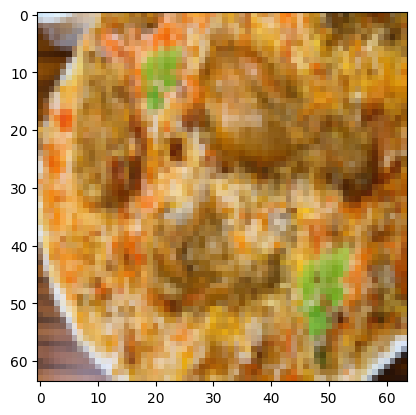

In [ ]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [ ]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed)

In [ ]:
custom_image_transformed.shape, custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [ ]:
model_0.eval()
with torch.inference_mode():
  custom_image_pred = model_0(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

tensor([[-1.6630,  0.3229,  0.7632]])

**Note, to make a prediction on a custom image we had to:**

Load the image and turn it into a tensor

Make sure the image was the same datatype as the model (torch.float32)

Make sure the image was the same shape as the data the model was trained on (3, 64, 64) with a batch size... (1, 3, 64, 64)

Make sure the image was on the same device as our model

In [ ]:
# Convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.0510, 0.3717, 0.5773]])

In [ ]:
# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1).cpu()
custom_image_pred_label

tensor([2])

In [ ]:
class_names[custom_image_pred_label]

'french_fries'